# 프로젝트 : Segmentation map으로 도로 이미지 만들기
***
***

### 데이터 로드하기
***

In [1]:
import tensorflow as tf
import numpy as np
import cv2 

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/'

train_path = data_path + '/train' 
val_path = data_path + '/val'

print('데이터 경로 : ', data_path)
print('학습 데이터 수 : ' , len(list(os.listdir(train_path))))
print('검증 데이터 수 : ' , len(list(os.listdir(val_path))))

데이터 경로 :  /aiffel/aiffel/conditional_generation/cityscapes/
학습 데이터 수 :  1000
검증 데이터 수 :  5


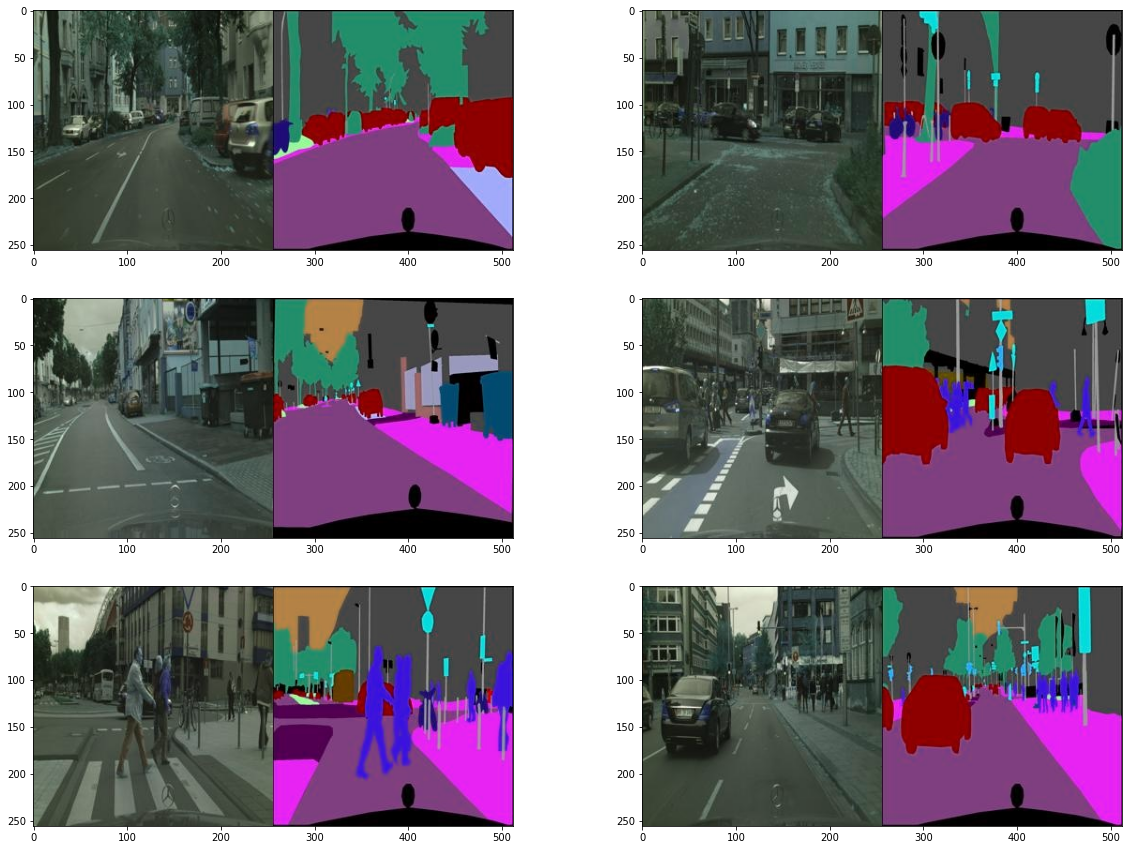

In [3]:
plt.figure(figsize=(20,15))

for i in range(1, 7):
    f = train_path + "/" +os.listdir(train_path)[np.random.randint(500)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

#### 이미지 크기 확인

In [4]:
f = train_path + "/" + os.listdir(train_path)[0]

img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


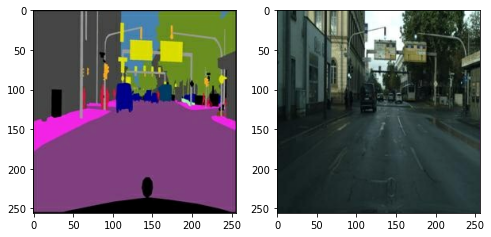

In [5]:
#필요한 함수 세팅
import tensorflow as tf

#컬러 채널을 노말라이즈
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) -1

#노말라이즈된 채널을 다시 복원
def denormalize(x):
    x = (x+1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

#이미지를 리얼/컬러로 나누어서 노말라이징하여 반환
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1]//2
    real = img[:, :w, :]
    real = tf.cast(real, tf.float32)
    
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    
    return normalize(colored), normalize(real)

#실제 train_path를 활용하여 하나의 이미지만 절반 잘라보기
f = train_path + "/" + os.listdir(train_path)[1]
real, colored = load_image(f)

plt.figure(figsize=(8,5))
plt.subplot(1,2,1); plt.imshow(denormalize(real))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## Augmentation 적용
***

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()
def apply_augmentation(real, colored):
    stacked = tf.concat([real, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    if tf.random.uniform(())<.5:
        padded = tf.pad(stacked, _pad, "REFLECT")
        
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
        
    #가로세로(256,512,3)이었던 사진을 절반으로 잘랐기에 크롭한다.
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
        
    #아까 합쳐두었던 real과 colored를 다시 3채널 3채널로 나누어 반환
    return out[..., :3], out[..., 3:]

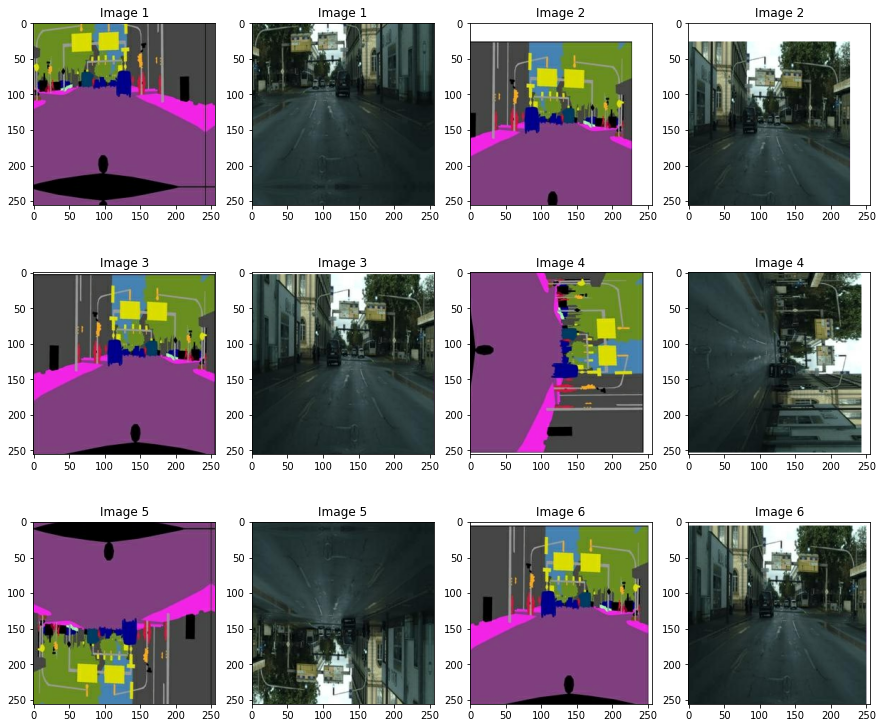

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_real, augmented_colored = apply_augmentation(real, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1    

/aiffel/aiffel/conditional_generation/cityscapes//train/


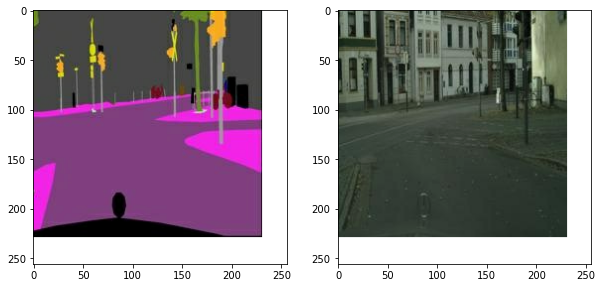

In [8]:
from tensorflow import data

def get_train(img_path):
    real, colored = load_image(img_path)
    real, colored = apply_augmentation(real, colored)
    return real, colored

train_path = data_path + '/train/' 
print(train_path)

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

##  Generator
***
* U-Net Generator 사용

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        
        if self.use_bn:
            x = self.batchnorm(x)
            
        return self.lrelu(x)

In [10]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        
        if self.dropout:
            x = layers.Dropout(0.5)(x)
            
        return self.relu(x)

### U-Net 기반의 Generator 사용

In [11]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator
***

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [15]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 학습 및 테스트
***

In [16]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [17]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [18]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        
        # 생성자 예측
        fake_colored = generator(sketch, training=True)
        
        # 판별자 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        
        # 생성자 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        
        # 판별자 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


####  10 epoch 학습, 중간 손실 값에 대한 로그

In [19]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (real, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(real, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8609                     
L1_loss:0.2976                     
Discriminator_loss:1.3283

EPOCH[1] - STEP[20]                     
Generator_loss:1.0338                     
L1_loss:0.2160                     
Discriminator_loss:1.6158

EPOCH[1] - STEP[30]                     
Generator_loss:0.8626                     
L1_loss:0.2032                     
Discriminator_loss:1.3030

EPOCH[1] - STEP[40]                     
Generator_loss:0.9658                     
L1_loss:0.1900                     
Discriminator_loss:1.1473

EPOCH[1] - STEP[50]                     
Generator_loss:0.9652                     
L1_loss:0.1887                     
Discriminator_loss:1.1178

EPOCH[1] - STEP[60]                     
Generator_loss:1.1323                     
L1_loss:0.1665                     
Discriminator_loss:1.2855

EPOCH[1] - STEP[70]                     
Generator_loss:1.2203                     
L1_loss:0.1937                    

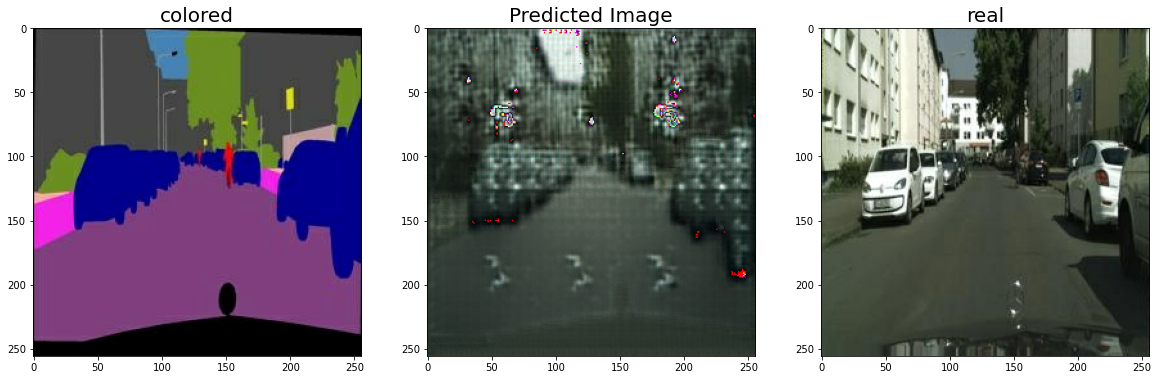

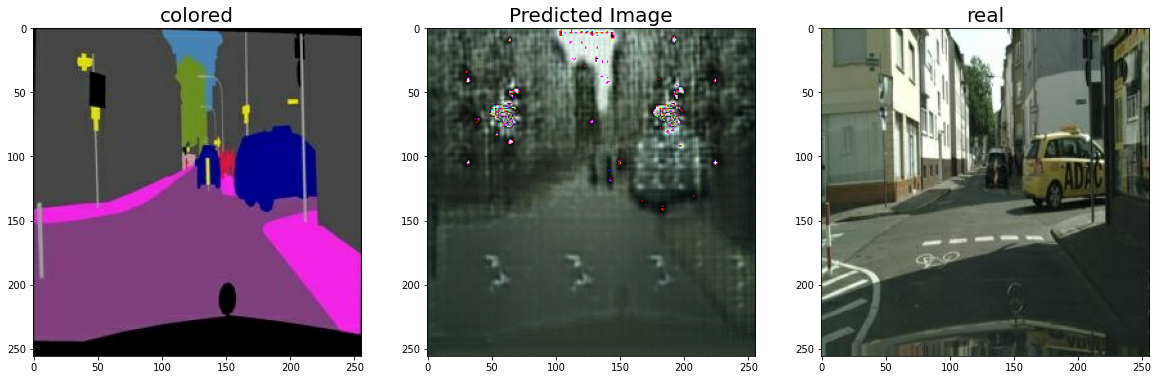

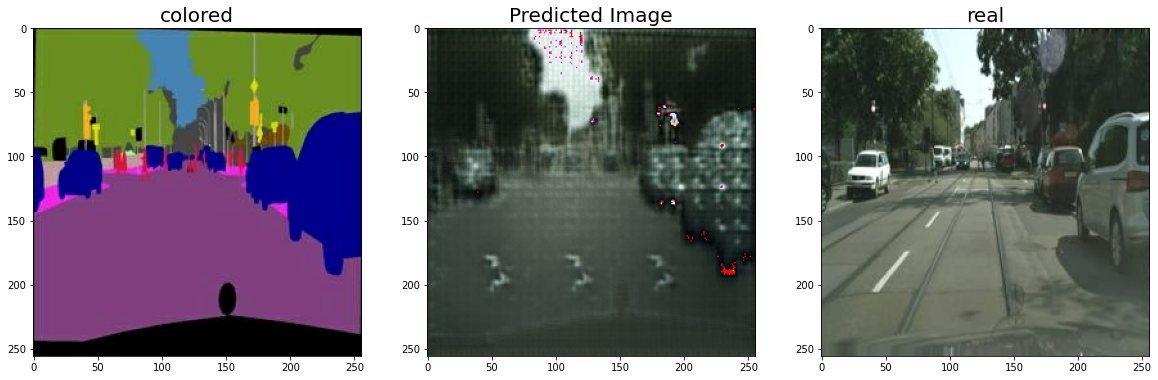

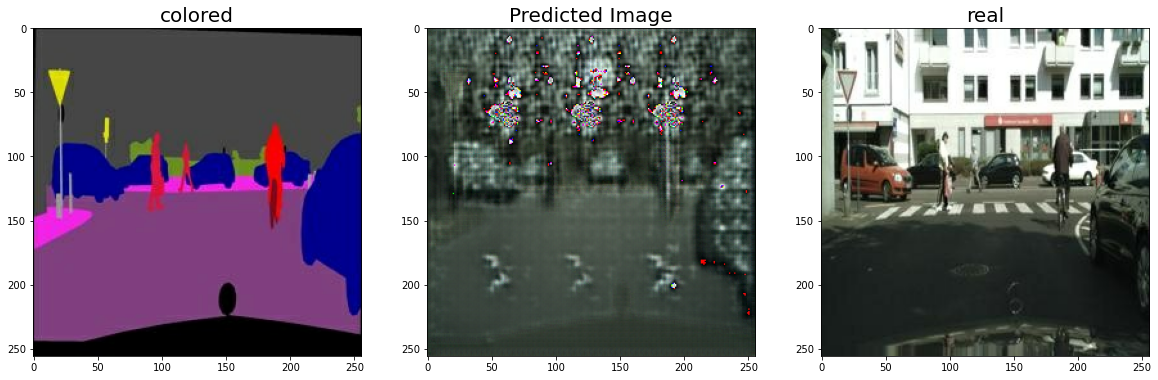

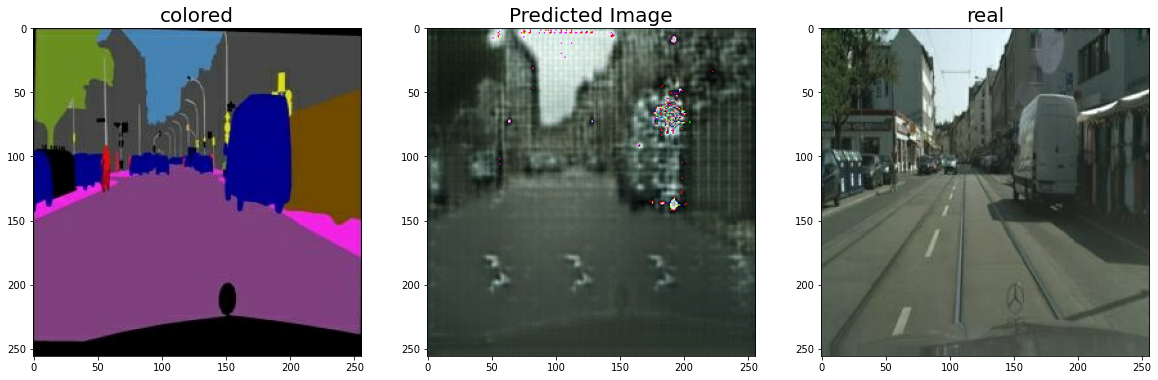

In [26]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_image(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('colored', fontsize=20)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('real', fontsize=20)

# 회고
***
흐릿하고 완전히 색이 다 채워지지는 않았지만 그럴싸한 이미지가 생성되는 것을 확인할 수 있었다.<br>
epoch를 늘린다면 조금 더 퀄리티가 올라갈 것으로 예상한다.<br>
